# Kalman Filter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as la
from scipy.stats import multivariate_normal as mvn

plt.style.use("seaborn-v0_8")

In [2]:
# Parameters for 1D motion dynamics
dt = 1.
R_var = 1
Q_var = 0.1

x_init = [0., 15.]
x = np.array(x_init).reshape(2, 1)
A = np.array([[1., dt], [0, 1.]])
C = np.array([[1., 0]])
P = np.diag([0.5, 0.1])  # covariance matrix for the state estimate
Q = np.diag([Q_var, Q_var])  # covariance matrix for the process disturbance
R = np.array([[R_var]])  # covariance matrix for the measurement noise

In [3]:
# Generate the ground truth 1D motion and noisy measurements 
num_iter = 20


def generate_1d_motion(x: np.ndarray, A: np.ndarray, count) -> (np.ndarray, np.ndarray):
    xs = [x]
    for i in range(count):
        x = A @ x
        xs.append(x)

    return np.array(xs)


def generate_1d_measurement(x: np.ndarray, C: np.ndarray, R: np.ndarray) -> (np.ndarray, np.ndarray):
    ys = []
    for i in range(x.shape[0]):
        y = C @ x[i, :]
        r, c = y.shape
        y += mvn.rvs(mean=np.zeros(r), cov=R, size=1)
        ys.append(y.reshape(r, ))

    return np.array(ys)


xs = generate_1d_motion(x, A, num_iter)
ys = generate_1d_measurement(xs, C, R)


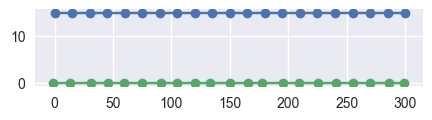

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.plot(xs[:, 0], xs[:, 1], 'o-')
ax.plot(ys, np.zeros_like(ys), 'o-')
plt.show()

## Prediction only

In [53]:
# Prediction only
N = 100

x_hat = np.array(x_init).reshape(2, 1)
x_hat += mvn.rvs(mean=np.zeros(2), cov=P, size=1).reshape(2, 1)

x_pred = np.zeros((num_iter + 1, N, 2))
x_pred[0, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

for i in range(num_iter):
    # prediction
    x_hat = A @ x_hat
    P = A @ P @ A.T + Q

    x_pred[i + 1, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

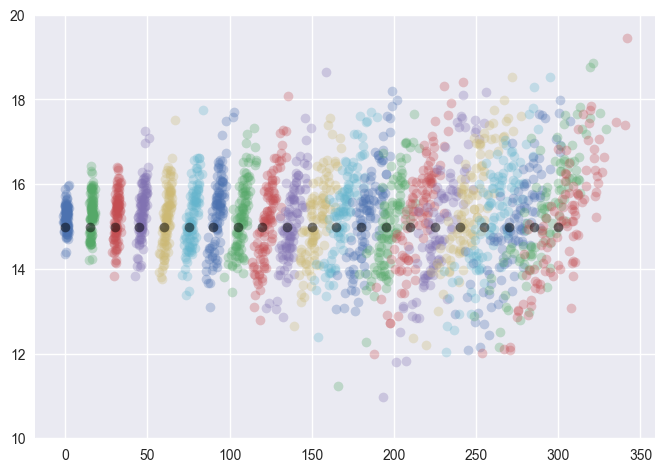

In [54]:
fig, ax = plt.subplots()

for z in range(num_iter + 1):
    ax.plot(x_pred[z, :, 0], x_pred[z, :, 1], 'o', alpha=0.3)

ax.plot(xs[:, 0], xs[:, 1], 'o', color='k', alpha=0.5)
ax.set_ylim(10, 20)

plt.show()

## Prediction and measurement update

In [23]:
# Define a number of iterations and an array to store the state estimates
N = 100
x_meas = np.zeros((num_iter + 1, N, 2))

# Initial noisy estimate and measurement
x_hat = np.array(x_init).reshape(2, 1)
x_hat += mvn.rvs(mean=np.zeros(2), cov=P, size=1).reshape(2, 1)


def kalman_gain(P: np.ndarray, C: np.ndarray, R: np.ndarray) -> np.ndarray:
    """Calculate the Kalman gain."""
    S = C @ P @ C.T + R
    K = P @ C.T @ la.inv(S)
    return K


K = kalman_gain(P, C, R)
x_hat = x_hat + K @ (ys[0] - C @ x_hat)
P = P - K @ C @ P

x_meas[0, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

print(x_hat)
# [[ 0.46355285]
#  [15.3781233 ]]

[[-1.00142342]
 [14.34815131]]


In [24]:
# Iterative prediction and measurement update
for i in range(num_iter):
    print(i)
    # prediction
    x_hat = A @ x_hat
    P = A @ P @ A.T + Q

    # measurement update    
    K = kalman_gain(P, C, R)
    x_hat = x_hat + K @ (ys[i + 1] - C @ x_hat)
    P = P - K @ C @ P

    x_meas[i + 1, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


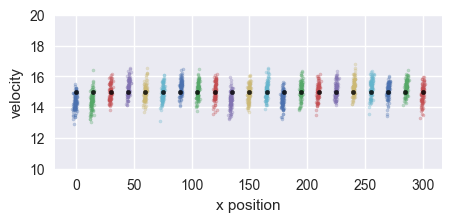

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))

for i in range(num_iter + 1):
    # Scatter plot
    ax.scatter(x_meas[i, :, 0], x_meas[i, :, 1], s=5, alpha=0.3)

# Plot the ground truth
ax.scatter(xs[:, 0], xs[:, 1], s=10, color='k', alpha=0.8)
ax.set_ylim(10, 20)
ax.set_xlabel('x position')
ax.set_ylabel('velocity')

plt.show()

In [34]:
x_meas[i, :, 0]

array([-0.51481094, -1.24375019, -1.04135565,  0.43396492, -1.71481556,
        0.62638624, -1.06161922, -2.70494397, -0.74448763, -0.77142225,
       -0.38183901, -1.95419654, -0.5160901 , -1.75460183, -1.59679656,
       -1.26759052, -1.14994439, -3.11202881,  0.66208839, -0.04535191,
       -0.76384359, -0.72704642, -0.56682659, -0.95607688, -1.84329797,
       -2.80134669,  0.71907055, -2.13373501,  0.02586475, -0.84556462,
        0.78777355,  0.83836899, -1.45583239, -0.0448475 , -1.19568996,
       -1.79225813, -1.33576026, -1.96097792, -1.43446458, -0.44518941,
       -0.23298626, -1.12029911, -1.12456401, -0.54796729, -1.20881663,
       -2.4220007 ,  0.2993643 , -0.19777611, -0.98753936, -0.31481225,
       -0.54857817, -1.46511884, -1.36176276, -1.46983225, -0.39637964,
       -0.81864477,  0.02156343, -0.09933678, -1.04844351, -2.53864013,
       -3.22392234, -0.20457121, -0.42067849, -0.23005978, -0.52407116,
       -0.56721938,  0.85590761, -0.73369249, -0.4572077 , -0.64